In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import gc

### loading the dataset as a tf.data.dataset object

In [2]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'C:\Users\VICTUS\Desktop\pattern project\RealWaste',
    batch_size=24,
    image_size=(256,256),     #resizing
    shuffle=True,
    seed=123
)

Found 4752 files belonging to 9 classes.


In [3]:
dataset.class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

(24, 256, 256, 3)
(24,)


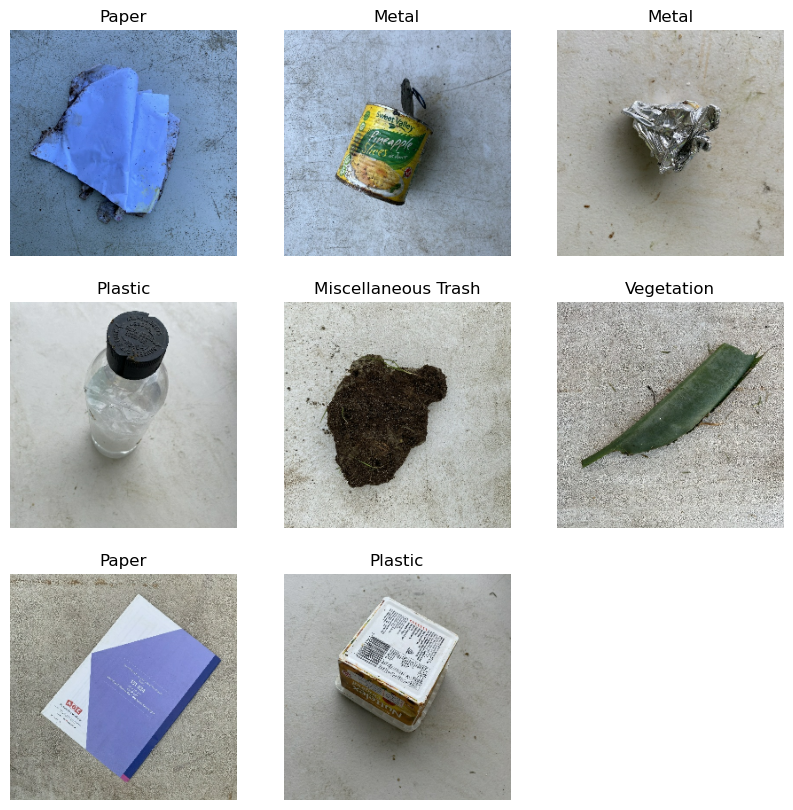

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):

  print(images.shape)
  print(labels.shape)

  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[i]])
    plt.axis("off")

In [5]:
len(dataset)

198

In [6]:
train_dataset=dataset.take(139)
remaining=dataset.skip(139)

print(f"Percentage of traning set {round(((len(train_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(remaining)/len(dataset))*100))} %")


Percentage of traning set 70 %
Percentage of test set 30 %


In [7]:
test_dataset=remaining.take(30)
cv_dataset=remaining.skip(30)
print(f"Percentage of traning set {round(((len(test_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(cv_dataset)/len(dataset))*100))} %")

Percentage of traning set 15 %
Percentage of test set 15 %


In [8]:
def class_counts(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, labels in dataset.unbatch():      # unbatch = go sample-by-sample
        if len(labels.shape) == 0:           
            counts[labels.numpy()] += 1
        else:                                # one-hot labels
            counts[np.argmax(labels.numpy())] += 1
    return counts

In [9]:
#dataset_counts = class_counts(dataset, 9)
#dataset_counts

In [10]:
#train_counts = class_counts(train_dataset, 9)
#train_counts

In [11]:
#test_counts = class_counts(test_dataset, 9)
#test_counts

In [12]:
#cv_counts = class_counts(cv_dataset, 9)
#cv_counts

In [13]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation

#preprocessing Pipeline
#normalizing the dataset

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(256,256)
])

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),  
    RandomZoom(0.1),  
    RandomTranslation(0.1, 0.1),  
])


In [ ]:
from keras import layers
model = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',input_shape=(256,256,3)),
    layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    #layers.Conv2D(64,kernel_size = (3,3), activation='relu',padding='same'),
    #layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    #layers.Conv2D(64,kernel_size = (3,3), activation='relu',padding='same'),
    #layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    #layers.Conv2D(128,kernel_size = (3,3), activation='relu',padding='same'),
    #layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    #layers.Conv2D(128,kernel_size = (3,3), activation='relu',padding='same'),
    #layers.MaxPooling2D((2, 2)),
    #Dropout(0.2),

    layers.Flatten(),
    Dropout(0.5),

    layers.Dense(64, activation='relu'),
    Dropout(0.2),
   
    layers.Dense(9, activation='softmax'),
])

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    restore_best_weights=True
)

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
history=model.fit(train_dataset,epochs=20,validation_data=cv_dataset)
#callbacks=[early_stop]

Epoch 1/20
139/139 [==============================] - 74s 416ms/step - loss: 2.2847 - accuracy: 0.2230 - val_loss: 1.8869 - val_accuracy: 0.3434
Epoch 2/20
139/139 [==============================] - 58s 415ms/step - loss: 1.7874 - accuracy: 0.3540 - val_loss: 1.8438 - val_accuracy: 0.4095
Epoch 3/20
139/139 [==============================] - 53s 377ms/step - loss: 1.6783 - accuracy: 0.4056 - val_loss: 1.5823 - val_accuracy: 0.4167
Epoch 4/20
139/139 [==============================] - 58s 413ms/step - loss: 1.6018 - accuracy: 0.4266 - val_loss: 1.5586 - val_accuracy: 0.4468
Epoch 5/20
139/139 [==============================] - 58s 413ms/step - loss: 1.4827 - accuracy: 0.4697 - val_loss: 1.4624 - val_accuracy: 0.4784
Epoch 6/20
139/139 [==============================] - 51s 365ms/step - loss: 1.4505 - accuracy: 0.4880 - val_loss: 1.3613 - val_accuracy: 0.5115
Epoch 7/20
139/139 [==============================] - 58s 415ms/step - loss: 1.3749 - accuracy: 0.5057 - val_loss: 1.3338 - val_ac

In [18]:
scores=model.evaluate(test_dataset)

30/30 [==============================] - 2s 26ms/step - loss: 0.9956 - accuracy: 0.6319


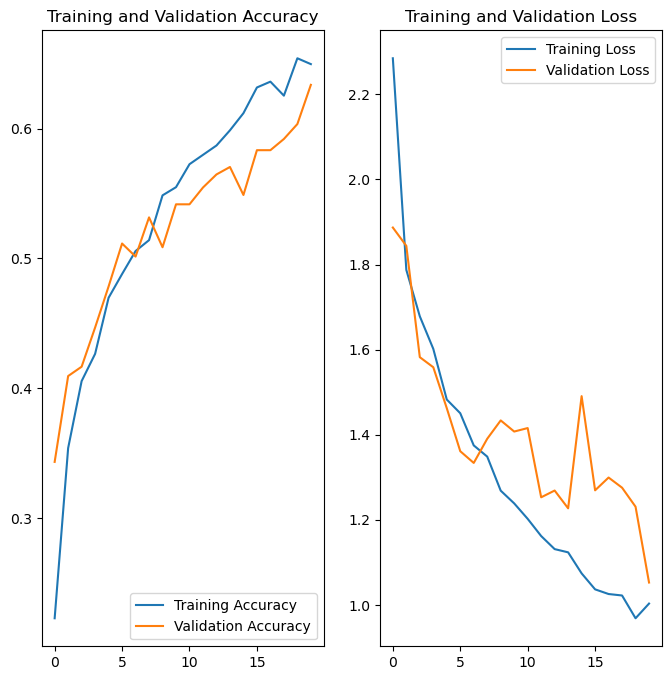

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(20), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), history.history['loss'], label='Training Loss')
plt.plot(range(20), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()